In [1]:
import numpy as np
import pandas as pd
from matplotlib import font_manager as fm, pyplot as plt, rcParams
import seaborn as sns
helv=fm.FontProperties(fname='helvetica.ttf')
from scipy.stats import *
import os

In [2]:
phenos = pd.read_table("/oak/stanford/groups/jpriest/cnv_ukb/gwas/chr16q112.two-var-phewas.v2.tsv",
                       names=["CNV","PHENO","N","BETA","SE","TSTAT","P"])

phenos['BIN'] = phenos['PHENO'].apply(lambda x: 'QT' not in x and 'INI' not in x)
phenos['BETA'] = phenos.apply(lambda x: np.log(x['BETA']) if x['BIN'] else x['BETA'], axis=1)  

with open("/oak/stanford/groups/mrivas/users/magu/repos/rivas-lab/ukbb-tools/05_gbe/icdinfo.txt", "r") as i:
    names = {line.split()[0]:line.split()[2] for line in i if int(line.split()[1]) > 499}
    
phenos['NAME'] = phenos['PHENO'].apply(lambda x: names.get(x) if x in names 
                                                 else names.get(x.replace('QT_FC', 'INI')) if x.replace('QT_FC','INI') in names 
                                                 else names.get(x.replace('BIN_FC','HC')))
phenos['-log10P'] = phenos['P'].apply(lambda x:-np.log10(x))

phenos.head(10)

/home/users/magu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


,CNV,PHENO,N,BETA,SE,TSTAT,P,BIN,NAME,-log10P
0,16:28818541-29043450_-,INI23112,327630,0.703353,0.165145,4.25899,2.054110e-05,False,Leg_fat_mass_(right),4.687376
1,16:29596230-30208637_-,INI23112,327630,1.043160,0.137866,7.56645,3.845420e-14,False,Leg_fat_mass_(right),13.415056
2,16:28818541-29043450_-,INI23104,327650,0.906749,0.206511,4.39080,1.129670e-05,False,Body_mass_index_(BMI),4.947048
3,16:29596230-30208637_-,INI23104,327650,1.322250,0.172399,7.66970,1.728690e-14,False,Body_mass_index_(BMI),13.762283
4,16:28818541-29043450_-,INI23130,327346,0.417243,0.129021,3.23392,1.221150e-03,False,Trunk_predicted_mass,2.913231
5,16:28818541-29043450_-,INI23113,327622,0.484962,0.132471,3.66090,2.513710e-04,False,Leg_fat-free_mass_(right),3.599685
6,16:28818541-29043450_-,INI24019,328014,0.203229,0.206449,0.98440,3.249190e-01,False,Particulate_matter_air_pollution_(pm10);_2007,0.488225
7,16:28818541-29043450_-,INI23106,327822,-0.549811,0.157913,-3.48174,4.982410e-04,False,Impedance_of_whole_body,3.302561
8,16:29596230-30208637_-,INI23106,327822,-0.456874,0.131836,-3.46546,5.293910e-04,False,Impedance_of_whole_body,3.276223
9,16:28818541-29043450_-,INI23108,327833,-0.783956,0.189060,-4.14660,3.375330e-05,False,Impedance_of_leg_(left),4.471684


In [3]:
phenos = phenos[~phenos['NAME'].isnull() & 
                (phenos['PHENO'] != "INI23098") & 
                (phenos['PHENO'] != "INI23104") & 
                (phenos['PHENO'] != "HC10002443")]

In [4]:
phenos[(phenos['P'] < 9e-6)].sort_values(['CNV','P']).head()

,CNV,PHENO,N,BETA,SE,TSTAT,P,BIN,NAME,-log10P
3494,16:28818541-29043450_-,INI30720,318651,1.20136,0.188790,6.36347,1.975110e-10,False,Cystatin_C,9.704409
3039,16:28818541-29043450_-,INI10030720,315192,1.25343,0.208302,6.01736,1.774790e-09,False,Cystatin_C_covariate_adjusted,8.750853
86,16:28818541-29043450_-,INI30300,319018,1.09072,0.201808,5.40473,6.495210e-08,False,High_light_scatter_reticulocyte_count,7.187407
425,16:28818541-29043450_-,INI30290,319018,1.04061,0.203724,5.10793,3.258910e-07,False,High_light_scatter_reticulocyte_percentage,6.486928
718,16:28818541-29043450_-,INI30250,319193,1.01627,0.201243,5.04995,4.421650e-07,False,Reticulocyte_count,6.354416


In [5]:
# hack the fact that beta/se for QTs is unitful
def standardize_coefs(row, phe_path):
    if phe_path is None:
        return None, None
    sd = pd.read_table(phe_path, sep='\s+', na_values=-9, header=None, index_col=None).iloc[:,-1].std()
    return row[['BETA', 'SE']]/sd

def get_phe_path(phe_id):
    with open('/oak/stanford/groups/mrivas/users/minneker/phenotype_ref/phe_app_path.tsv', 'r') as f:
        for line in f:
            if line.split()[0] == phe_id:
                return line.split()[-1]
    return None

/home/users/magu/.local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


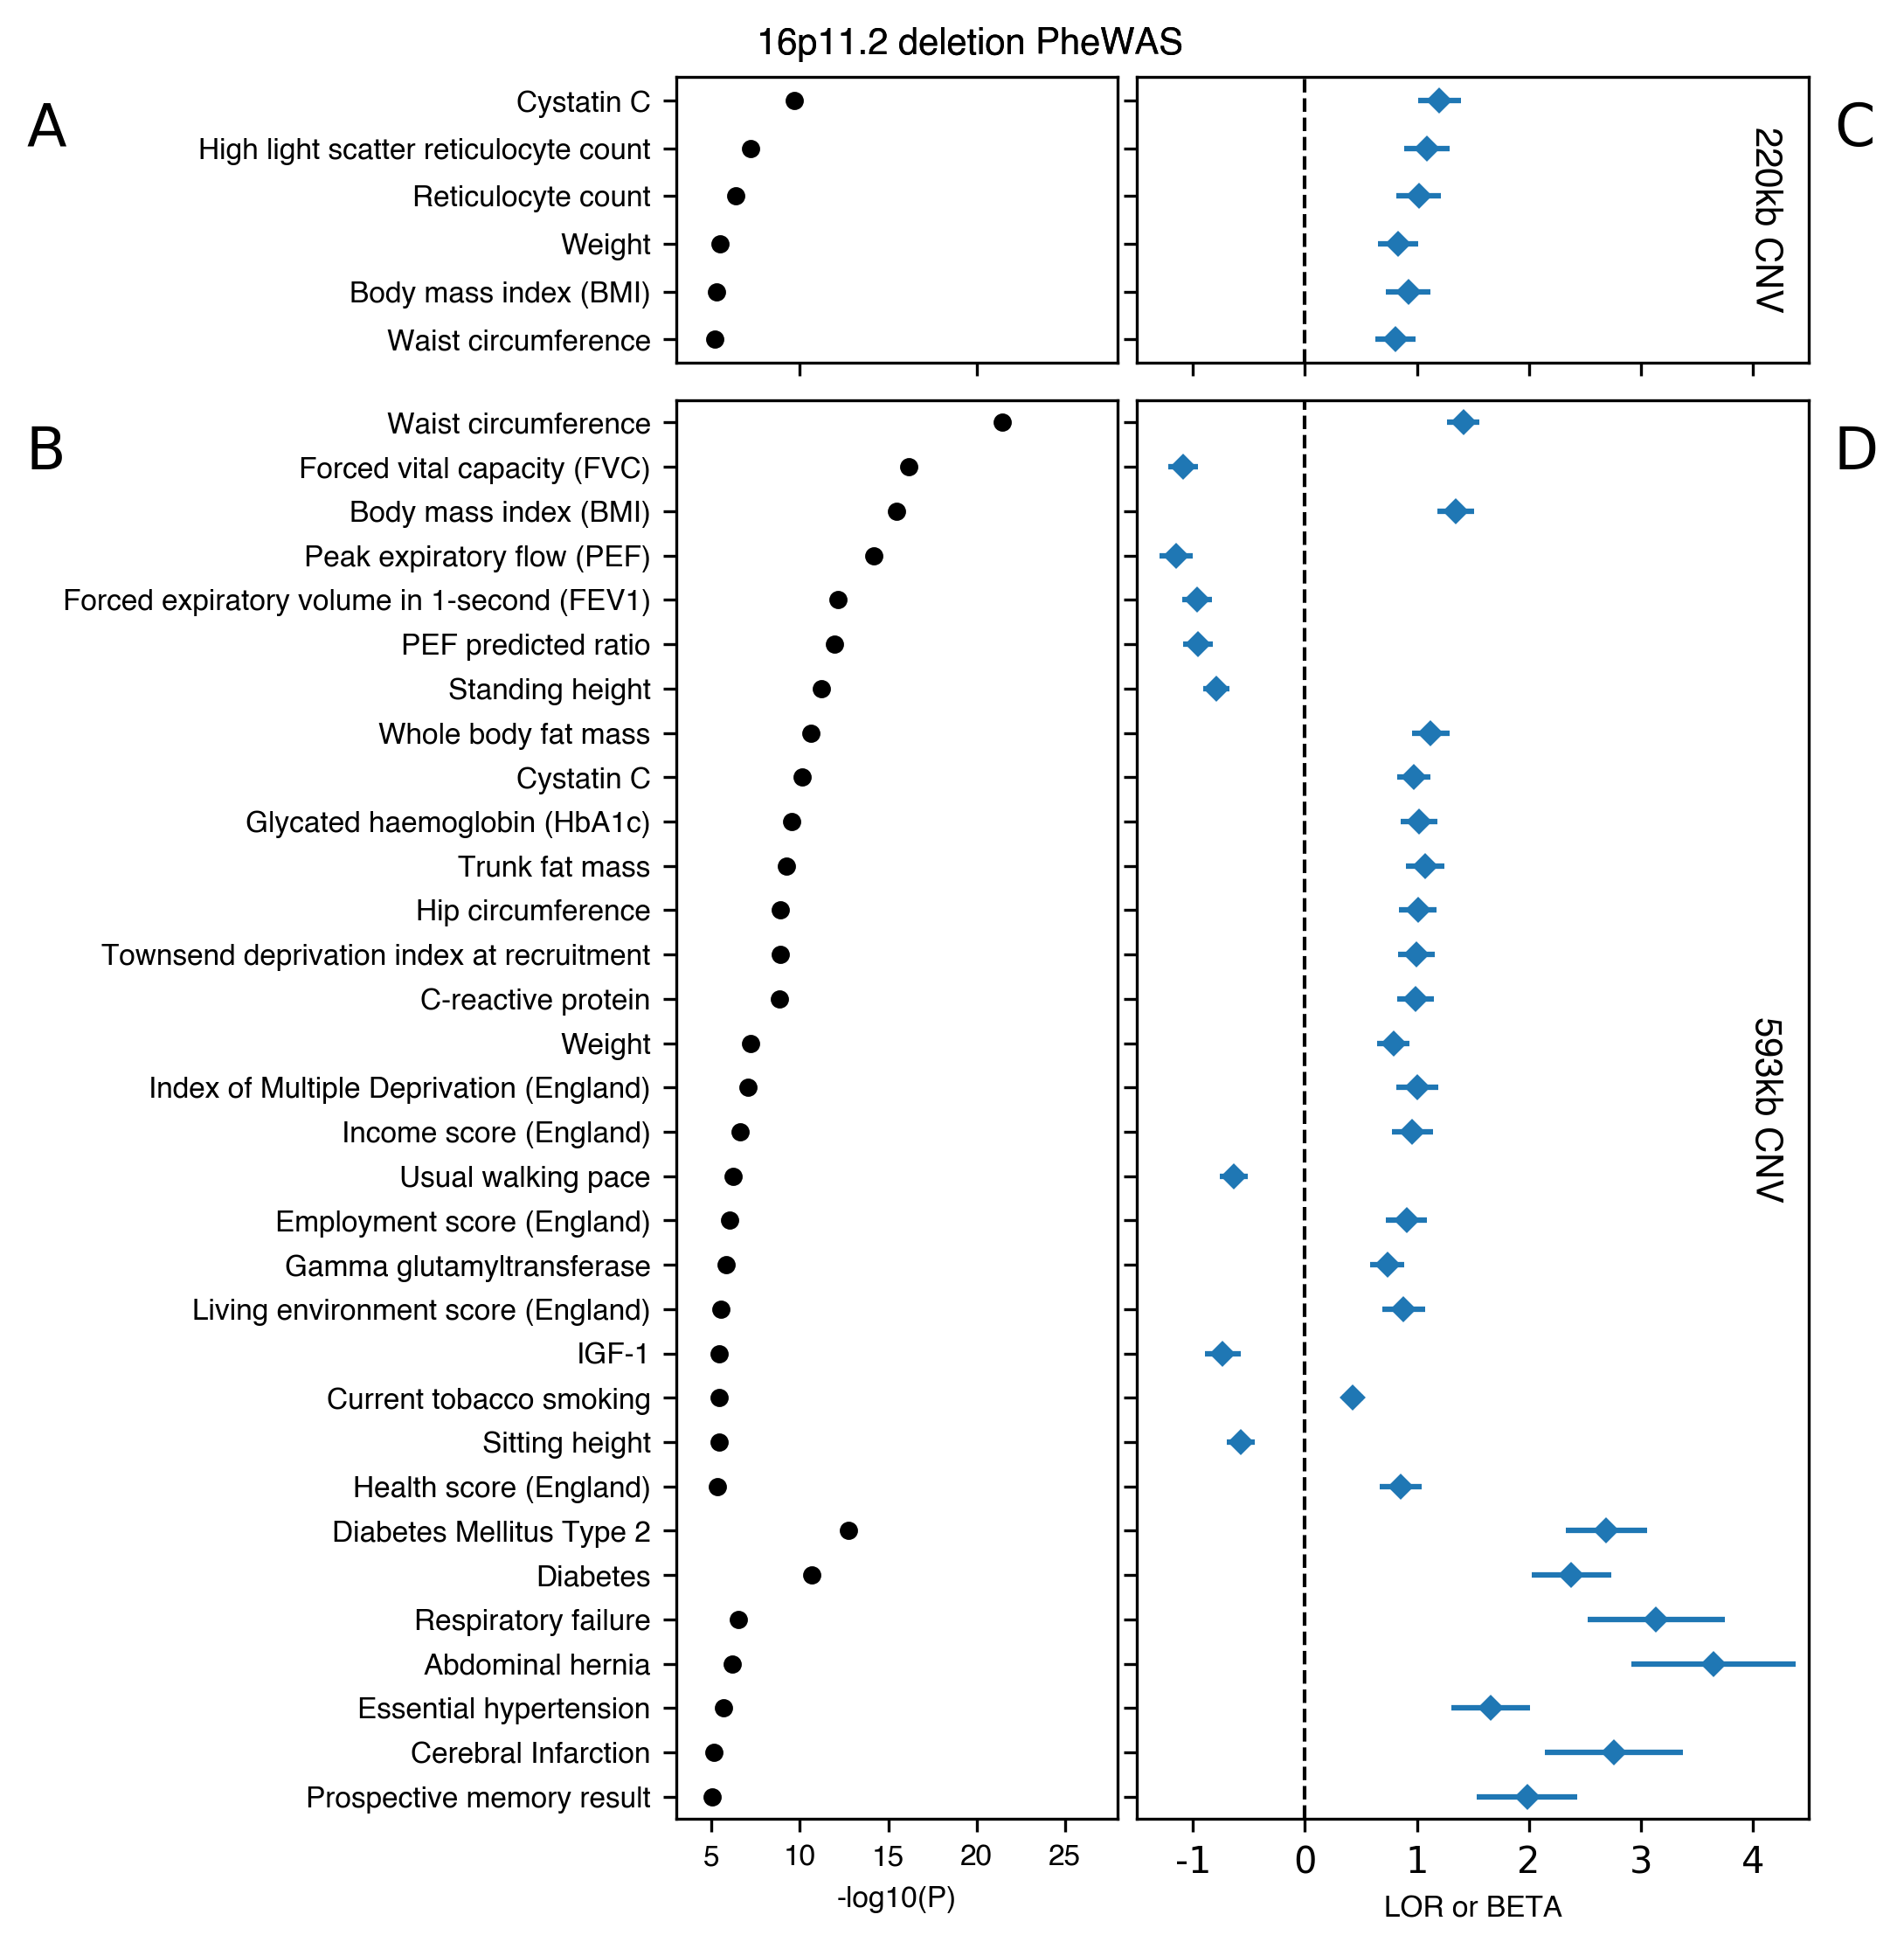

In [6]:
# do the plot
filter_kw = lambda s: all([i not in s for i in ['doctor','left','right','percentage','Best','adjusted']])

y_ht = int(0.4*24) + 2
frac=8/10.0
fig  = plt.figure(figsize=(10*frac, y_ht*frac), dpi=300, tight_layout=True)
grid = plt.GridSpec(y_ht, 10, hspace=0.3)


for cnv_ix, cnv in enumerate(["16:28818541-29043450_-", "16:29596230-30208637_-"]):
    # select significant data, truncate visualization
    data = phenos.loc[(~phenos['NAME'].isnull()) & 
                      (phenos['NAME'].apply(filter_kw))].query('CNV==@cnv & P < 9e-6').copy()
    
    # apply the hack from the above cell
    # data[['S_BETA', 'S_SE']] = data.apply(lambda x: x[['BETA', 'SE']] if x['BIN'] 
    #                                                else standardize_coefs(x, get_phe_path(x['PHENO'])), axis=1)
    data[['S_BETA','S_SE']] = data[['BETA','SE']]
    
    data = data.query('S_SE < 1').sort_values('P').head(50).copy()
    # group by QT/BIN status, plus fat measurement for second CNV
    order = [irow[0] for irow in sorted([irow for irow in data.iterrows()], 
                                         key=lambda (i,x): -x['P'] - 100*x['BIN'])] 

    # title
    fig.text(0.5, 0.89, '16p11.2 deletion PheWAS', horizontalalignment='center', fontsize=11, fontproperties=helv)
    
    # p-values
    if cnv_ix == 0:
        xb = int(0.3 * data.shape[0]) + 1
        ax = fig.add_subplot(grid[:xb,:4])
    else:
        ax = fig.add_subplot(grid[xb:,:4])
    ax.plot([data.loc[i,'-log10P'] for i in order], list(range(len(order))), 'ko', ms=4)
    ax.set_ylim(-0.5,len(order)-0.5)
    ax.set_yticks(list(range(len(order)))) 
    ax.set_yticklabels(list(map(lambda s:s[0].upper() + s[1:].replace('_',' '), 
                                [data.loc[i,'NAME'] for i in order])),
                       fontsize=8, fontproperties=helv)
    if cnv_ix == 1:
        ax.set_xlabel('-log10(P)', fontsize=8, fontproperties=helv)
        ax.set_xticks([5,10,15,20,25])
        ax.set_xticklabels(['5','10','15','20','25'], fontsize=8, fontproperties=helv)
    else:
        ax.set_xticklabels(['' for _ in ax.get_xticklabels()])
    ax.set_xlim(3,28)

    # betas
    if cnv_ix == 0:
        ax = fig.add_subplot(grid[:xb,4:])
    else:
        ax = fig.add_subplot(grid[xb:,4:])
    ax.errorbar(x=[data.loc[i,'S_BETA'] for i in order], 
                y=list(range(len(order))),
                xerr=[data.loc[i,'S_SE'] for i in order],
                linestyle='', marker='D', ms=4)
    ax.set_ylim(-0.5,len(order)-0.5)
    ax.set_yticks(list(range(len(order))))
    ax.set_yticklabels(['' for _ in order])
    if cnv_ix == 1:
        ax.set_xlabel('LOR or BETA', fontsize=8, fontproperties=helv)
        ax.set_xticks([-1,0,1,2,3,4])
        ax.set_xticklabels(['-1','0','1','2','3','4'])
    else:
        ax.set_xticklabels(['' for _ in ax.get_xticklabels()])
    ax.set_xlim(-1.5,4.5)
    ax.set_ylabel('\n220kb CNV' if cnv_ix==0 else '\n593kb CNV', rotation=270, fontsize=7, fontproperties=helv)
    ax.yaxis.set_label_position("right")

    # dash line for betas
    plt.plot([0,0], ax.get_ylim(), 'k--', linewidth=1)

fig.text(0.05, 0.85, 'A', fontsize=16), fig.text(.912, 0.85, 'C', fontsize=16)
fig.text(0.05, 0.71, 'B', fontsize=16), fig.text(.912, 0.71, 'D', fontsize=16)
fig.subplots_adjust(left=0.36)
plt.savefig('output/Figure4.pdf')
plt.show()